In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os

from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
trainingList = pd.DataFrame(columns = ['label'])
evaluationList = pd.DataFrame(columns = ['label'])
validateList = pd.DataFrame(columns = ['label'])

for root, dirs, files in os.walk('Food-5K/training', topdown=False):
    for file in files:
        try:
            image = Image.open(root+'/'+file)
            imageResize = tf.image.resize(image, [50,50], method='nearest', preserve_aspect_ratio=False)
            imageFlatten = tf.reshape(imageResize, [7500]).numpy()
            trainingList = pd.concat([trainingList, pd.DataFrame(imageFlatten).T], ignore_index=True)
            trainingList.loc[trainingList.shape[0]-1,'label'] = int(file[0])
        except Exception:
            print('Error getting training image on image ' + file)
            
    for root, dirs, files in os.walk('Food-5K/evaluation', topdown=False):
        for file in files:
            try:
                image = Image.open(root+'/'+file)
                imageResize = tf.image.resize(image, [50,50], method='nearest', preserve_aspect_ratio=False)
                imageFlatten = tf.reshape(imageResize, [7500]).numpy()
                evaluationList = pd.concat([evaluationList, pd.DataFrame(imageFlatten).T], ignore_index=True)
                evaluationList.loc[evaluationList.shape[0]-1,'label'] = int(file[0])
            except Exception:
                print('Error getting evaluation image on image ' + file)
            
    for root, dirs, files in os.walk('Food-5K/validation', topdown=False):
        for file in files:
            try:
                image = Image.open(root+'/'+file)
                imageResize = tf.image.resize(image, [50,50], method='nearest', preserve_aspect_ratio=False)
                imageFlatten = tf.reshape(imageResize, [7500]).numpy()
                validateList = pd.concat([validateList, pd.DataFrame(imageFlatten).T], ignore_index=True)
                validateList.loc[validateList.shape[0]-1,'label'] = int(file[0])
            except Exception:
                print('Error getting testing image on image ' + file)
                
trainPlusValidate = pd.concat([trainingList, validateList], ignore_index=True)
trainPlusValidate = trainPlusValidate.sample(frac=1)

Error getting training image on image .DS_Store
Error getting training image on image 0_1299.jpg
Error getting training image on image 0_1310.jpg
Error getting training image on image 0_1325.jpg
Error getting training image on image 0_1423.jpg
Error getting training image on image 0_1435.jpg
Error getting training image on image 0_1472.jpg
Error getting training image on image 0_1488.jpg
Error getting training image on image 0_511.jpg
Error getting evaluation image on image .DS_Store
Error getting testing image on image .DS_Store
Error getting testing image on image 0_451.jpg
Error getting testing image on image 0_455.jpg
Error getting testing image on image 0_478.jpg


In [3]:
%store trainingList
%store evaluationList
%store validateList

Stored 'trainingList' (DataFrame)
Stored 'evaluationList' (DataFrame)
Stored 'validateList' (DataFrame)


In [2]:
%store -r trainingList
%store -r evaluationList
%store -r validateList

(array([1989.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2000.]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <BarContainer object of 10 artists>)

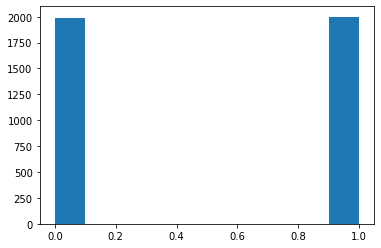

In [14]:
plt.hist(trainPlusValidate['label'])

In [4]:
gbm_param_grid = {
    'n_neighbors' : [10, 20, 30, 40, 50, 80, 100, 300, 600, 1000],
    'weights': ['uniform'],
    'metric': ['manhattan']
}

gs = RandomizedSearchCV(
    KNeighborsClassifier(),
    gbm_param_grid,
    cv = 3,
    verbose = 4,
    n_jobs = -1
    )

gs.fit(trainPlusValidate.drop(['label'], axis=1), trainPlusValidate['label'].astype('int'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [30, 40, 50, 70, 80, 100,
                                                        140, 300, 600, 800,
                                                        1000],
                                        'weights': ['uniform']},
                   verbose=4)

In [5]:
%store gs

Stored 'gs' (RandomizedSearchCV)


In [3]:
%store -r gs

In [16]:
nnTrainScore = gs.score(trainPlusValidate.drop(['label'], axis=1), trainPlusValidate['label'].astype('int'))
nnEvaluateScore = gs.score(evaluationList.drop(['label'], axis=1), evaluationList['label'].astype('int'))

print('Train score ' + str(nnTrainScore))
print('Evaluate score ' + str(nnEvaluateScore))

Train score 0.7996991727249937
Evaluate score 0.761


In [45]:
gs.best_params_

{'weights': 'uniform', 'n_neighbors': 40, 'metric': 'manhattan'}

In [30]:
params_nn = pd.concat([pd.DataFrame(gs.cv_results_["params"]),pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
params_nn = params_nn.sort_values(by=['n_neighbors'])
params_nn = params_nn.drop(['weights', 'metric'], axis=1)

In [31]:
params_nn

,n_neighbors,Accuracy
7,40,0.784908
0,50,0.777889
5,70,0.776887
2,80,0.781901
8,100,0.772123
1,140,0.774629
9,300,0.756830
3,600,0.745798
4,800,0.735771
6,1000,0.722232


<AxesSubplot:xlabel='n_neighbors'>

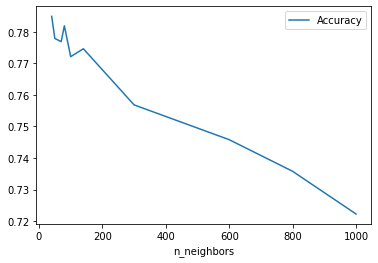

In [33]:
params_nn.plot(kind='line',x='n_neighbors',y='Accuracy')

In [12]:
gs_svm.best_params_

{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 1200}

In [13]:
svm_param_grid = {
    'learning_rate': ['constant'],
    'eta0': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [300, 600, 900, 1200, 1500],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

gs_svm = GridSearchCV(SGDClassifier(loss='hinge'),
            svm_param_grid,
            cv = 3,
            verbose = 4,
            n_jobs = -1
            )

gs_svm.fit(trainPlusValidate.drop(['label'], axis=1), trainPlusValidate['label'].astype('int'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1],
                         'learning_rate': ['constant'],
                         'max_iter': [300, 600, 900, 1200, 1500]},
             verbose=4)

In [ ]:
%store gs_svm

In [ ]:
%store -r gs_svm

In [17]:
svmTrainScore = gs_svm.score(trainPlusValidate.drop(['label'], axis=1), trainPlusValidate['label'].astype('int'))
svmEvaluateScore = gs_svm.score(evaluationList.drop(['label'], axis=1), evaluationList['label'].astype('int'))

print('Train score ' + str(svmTrainScore))
print('Evaluate score ' + str(svmEvaluateScore))

Train score 0.7282526949110053
Evaluate score 0.672


In [34]:
params_svm = pd.concat([pd.DataFrame(gs_svm.cv_results_["params"]),pd.DataFrame(gs_svm.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [44]:
params_svm.loc[params_svm['max_iter'] == 1200 ].sort_values(by=['Accuracy']).drop(['learning_rate'], axis=1)

,alpha,eta0,max_iter,Accuracy
98,0.10000,0.1000,1200,0.519424
78,0.01000,0.1000,1200,0.666099
88,0.10000,0.0010,1200,0.672811
93,0.10000,0.0100,1200,0.678121
18,0.00001,0.1000,1200,0.691156
73,0.01000,0.0100,1200,0.697894
28,0.00010,0.0010,1200,0.709701
58,0.00100,0.1000,1200,0.710220
3,0.00001,0.0001,1200,0.712706
53,0.00100,0.0100,1200,0.712964


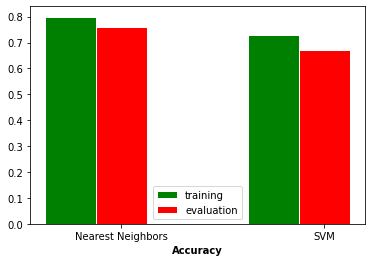

In [20]:
# Print a bar chart with groups

import numpy as np
import matplotlib.pyplot as plt

# set height of bar
# length of these lists determine the number
# of groups (they must all be the same length)
bars1 = [nnTrainScore, svmTrainScore]
bars2 = [nnEvaluateScore, svmEvaluateScore]

# set width of bar. To work and supply some padding
# the number of groups times barWidth must be
# a little less than 1 (since the next group
# will start at 1, then 2, etc).

barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='training')
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label='evaluation')

# Add xticks on the middle of the group bars
plt.xlabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Nearest Neighbors', 'SVM'])

# Create legend & Show graphic
plt.legend()
plt.show()
#plt.savefig("barChart.pdf",dpi=400,bbox_inches='tight',pad_inches=0.05) # save as a pdf